### 0. CONSTANT PARAMETER

In [1]:
RR_TARGET = 1.5                             # R:R
ATR_MULT  = 1.2                             # SL = ATR * ATR_MULT (เริ่ม 1.2 เพื่อลด both-hit)
K_BARS    = 16                              # เวลารอผล TP/SL
COST_R    = 0.10                            # ค่าธรรมเนียม/สลิปเป็น R
P_MIN     = (1 + COST_R) / (RR_TARGET + 1)  # เกณฑ์คุ้มทุนเชิงทฤษฎี
COOLDOWN  = 6

In [2]:
import numpy as np
import pandas as pd

def ensure_datetime_index(df):
    d = df.copy()
    if 'datetime' in d.columns:
        d['datetime'] = pd.to_datetime(d['datetime'], errors='coerce')
        d = d.set_index('datetime')
    if not isinstance(d.index, pd.DatetimeIndex):
        d.index = pd.to_datetime(d.index, errors='coerce')
    d = d[~d.index.isna()].sort_index()
    d = d[~d.index.duplicated(keep='first')]
    return d

In [3]:
def make_outcome(df, side, atr_mult=ATR_MULT, rr=RR_TARGET, k=K_BARS):
    n   = len(df)
    out = np.full(n, -1, np.int8)  # -1 none, 0 sl, 1 tp

    for i in range(n - k - 1):
        entry = df['close'].iloc[i]
        stop  = atr_mult * df['atr'].iloc[i]
        if stop <= 0 or np.isnan(stop):
            continue

        hh = df['high'].iloc[i+1:i+1+k].to_numpy()
        ll = df['low' ].iloc[i+1:i+1+k].to_numpy()

        if side == 'long':
            tp = entry + rr*stop; sl = entry - stop
            if hh.max() >= tp and ll.min() <= sl:
                for j in range(i+1, i+1+k):
                    if df['high'].iloc[j] >= tp: out[i] = 1; break
                    if df['low' ].iloc[j] <= sl: out[i] = 0; break
            elif hh.max() >= tp: out[i] = 1
            elif ll.min() <= sl: out[i] = 0
        else:  # short
            tp = entry - rr*stop; sl = entry + stop
            if ll.min() <= tp and hh.max() >= sl:
                for j in range(i+1, i+1+k):
                    if df['low' ].iloc[j] <= tp: out[i] = 1; break
                    if df['high'].iloc[j] >= sl: out[i] = 0; break
            elif ll.min() <= tp: out[i] = 1
            elif hh.max() >= sl: out[i] = 0

    # ✅ รีเทิร์นเป็น DataFrame ผูก index เดิม
    return pd.DataFrame({f'{side}_outcome': out}, index=df.index)

## 1. Setup

In [4]:
!pip install -q mplfinance
!pip install -q ta

## 2. Load & Sanity

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!ls -al /content/drive/MyDrive/IS_Safem0de

total 1416
drwx------ 2 root root    4096 Nov  3 04:15 colab
drwx------ 2 root root    4096 Nov  3 03:28 data
-rw------- 1 root root 1433206 Oct 16 03:59 EURUSD_H4.csv
drwx------ 2 root root    4096 Nov  3 02:47 paper
drwx------ 2 root root    4096 Nov  3 02:48 prelim_midterm


In [7]:
data_path = '/content/drive/MyDrive/IS_Safem0de/EURUSD_H4.csv'

In [8]:
import pandas as pd

df = pd.read_csv(data_path)
df.tail()

,2009-10-05 20:00,1.46469,1.46609,1.46436,1.46558,2247
25842,2025-10-15 08:00,1.16355,1.16453,1.16195,1.16199,16243
25843,2025-10-15 12:00,1.16201,1.16472,1.16103,1.16369,25939
25844,2025-10-15 16:00,1.16371,1.16448,1.16269,1.16441,14745
25845,2025-10-15 20:00,1.16442,1.16519,1.16418,1.16456,5554
25846,2025-10-16 00:00,1.16455,1.16754,1.16425,1.16659,14450


In [9]:
# ตรวจชื่อคอลัมน์
df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

# แปลง datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# ตั้ง index เป็นเวลา (สะดวกกับการ plot)
df.set_index('datetime', inplace=True)

print(df.index.min(), df.index.max(), len(df))
df.head()

2009-10-06 00:00:00 2025-10-16 00:00:00 25847


,open,high,low,close,volume
datetime,,,,,
2009-10-06 00:00:00,1.46563,1.47178,1.46541,1.47035,10300
2009-10-06 04:00:00,1.47051,1.47486,1.46951,1.47169,12566
2009-10-06 08:00:00,1.47176,1.47458,1.47068,1.47264,18816
2009-10-06 12:00:00,1.47270,1.47612,1.46951,1.47416,15619
2009-10-06 16:00:00,1.47409,1.47537,1.47023,1.47160,13948


In [10]:
# 1) ทำให้ index เป็น Datetime ที่เรียงและไม่ซ้ำ
df = ensure_datetime_index(df)

# 2) TDD checks เบื้องต้น
assert isinstance(df.index, pd.DatetimeIndex)
assert df.index.is_monotonic_increasing
assert not df.index.has_duplicates
assert {'open','high','low','close'}.issubset(df.columns)

print(df.index.min(), '→', df.index.max(), 'rows=', len(df))
display(df.head(3)); display(df.tail(3))

2009-10-06 00:00:00 → 2025-10-16 00:00:00 rows= 25847


,open,high,low,close,volume
datetime,,,,,
2009-10-06 00:00:00,1.46563,1.47178,1.46541,1.47035,10300
2009-10-06 04:00:00,1.47051,1.47486,1.46951,1.47169,12566
2009-10-06 08:00:00,1.47176,1.47458,1.47068,1.47264,18816


,open,high,low,close,volume
datetime,,,,,
2025-10-15 16:00:00,1.16371,1.16448,1.16269,1.16441,14745
2025-10-15 20:00:00,1.16442,1.16519,1.16418,1.16456,5554
2025-10-16 00:00:00,1.16455,1.16754,1.16425,1.16659,14450


In [11]:
dfc = ensure_datetime_index(df)
dfc.tail()

,open,high,low,close,volume
datetime,,,,,
2025-10-15 08:00:00,1.16355,1.16453,1.16195,1.16199,16243
2025-10-15 12:00:00,1.16201,1.16472,1.16103,1.16369,25939
2025-10-15 16:00:00,1.16371,1.16448,1.16269,1.16441,14745
2025-10-15 20:00:00,1.16442,1.16519,1.16418,1.16456,5554
2025-10-16 00:00:00,1.16455,1.16754,1.16425,1.16659,14450


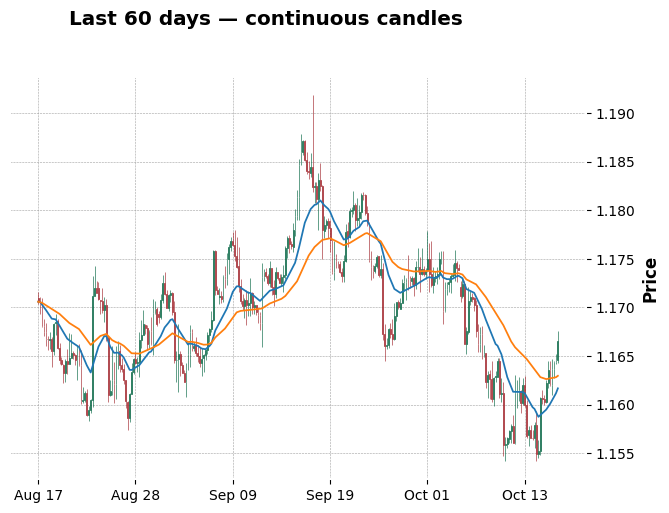

In [12]:
import mplfinance as mpf
import pandas as pd

def plot_candles_continuous(df, start=None, end=None, add_ema=True, title=None):
    # เลือกช่วงเวลา
    d = df.loc[str(start):str(end)] if (start or end) else df
    if d.empty:
        print("No data in range"); return

    # เตรียมเส้นซ้อน (ถ้าต้องการ)
    aps = []
    if add_ema:
        if 'ema20' not in d.columns:
            d = d.copy()
            d['ema20'] = d['close'].ewm(span=20, adjust=False).mean()
            d['ema50'] = d['close'].ewm(span=50, adjust=False).mean()
        aps = [
            mpf.make_addplot(d['ema20'], panel=0),
            mpf.make_addplot(d['ema50'], panel=0),
        ]

    mpf.plot(
        d[['open','high','low','close']],
        type='candle',
        style='charles',
        addplot=aps,
        volume=False,
        show_nontrading=False,  # << สำคัญ: ให้กราฟ “ต่อกัน”
        datetime_format='%b %d',
        xrotation=0,
        title=title or 'Candles (continuous)'
    )

# ตัวอย่างใช้งาน: 60 วันท้าย
plot_candles_continuous(
    df,
    start=df.index.max() - pd.Timedelta(days=60),
    end=df.index.max(),
    add_ema=True,
    title='Last 60 days — continuous candles'
)

In [13]:
from ta.volatility import AverageTrueRange

def build_core_features_basic(df, atr_window=14, ema_fast=20, ema_slow=50):
    d = df.copy()
    d['ema20'] = d['close'].ewm(span=ema_fast, adjust=False).mean()
    d['ema50'] = d['close'].ewm(span=ema_slow, adjust=False).mean()
    atr = AverageTrueRange(d['high'], d['low'], d['close'], window=atr_window)
    d['atr'] = atr.average_true_range()

    # vol_z = std(logret) 50 / 200
    logret = np.log(d['close']).diff()
    d['vol_z'] = (logret.rolling(50, min_periods=25).std() /
                  logret.rolling(200, min_periods=100).std())
    return d

In [14]:
dfc = build_core_features_basic(df)   # ที่คุณมีอยู่แล้ว (EMA/ATR/VolZ)
dfc.tail()

,open,high,low,close,volume,ema20,ema50,atr,vol_z
datetime,,,,,,,,,
2025-10-15 08:00:00,1.16355,1.16453,1.16195,1.16199,16243,1.160077,1.162636,0.002738,1.197292
2025-10-15 12:00:00,1.16201,1.16472,1.16103,1.16369,25939,1.160421,1.162678,0.002806,1.201422
2025-10-15 16:00:00,1.16371,1.16448,1.16269,1.16441,14745,1.160801,1.162746,0.002734,1.203829
2025-10-15 20:00:00,1.16442,1.16519,1.16418,1.16456,5554,1.161159,1.162817,0.002611,1.205963
2025-10-16 00:00:00,1.16455,1.16754,1.16425,1.16659,14450,1.161676,1.162965,0.002659,1.199740


In [15]:
import mplfinance as mpf
import pandas as pd

def plot_core_dashboard_v2(df, start=None, end=None,
                           atr_thr=0.0030,
                           hspace=0.30,
                           title='Candles+EMA / ATR / VolZ (continuous)'):
    d = df.loc[str(start):str(end)] if (start or end) else df
    if d.empty:
        print("No data in range"); return

    ap = [
        mpf.make_addplot(d['ema20'], panel=0),
        mpf.make_addplot(d['ema50'], panel=0),

        mpf.make_addplot(d['atr'],   panel=1),
        mpf.make_addplot(pd.Series(atr_thr, index=d.index), panel=1, linestyle='--'),

        mpf.make_addplot(d['vol_z'], panel=2),
        mpf.make_addplot(pd.Series(1.0, index=d.index),     panel=2, linestyle='--'),
    ]

    # ❗️ไม่มี show=...
    fig, axes = mpf.plot(
        d[['open','high','low','close']],
        type='candle', style='charles',
        addplot=ap, volume=False,
        show_nontrading=False,
        panel_ratios=(3,1,1),
        figratio=(16,9), figscale=1.0,
        title=title,
        returnfig=True
    )

    axes[0].set_ylabel("Price")
    axes[1].set_ylabel("ATR")
    axes[2].set_ylabel("VolZ")

    fig.subplots_adjust(hspace=hspace)

    mpf.show()   # ✅ แสดงผลหลังปรับ layout


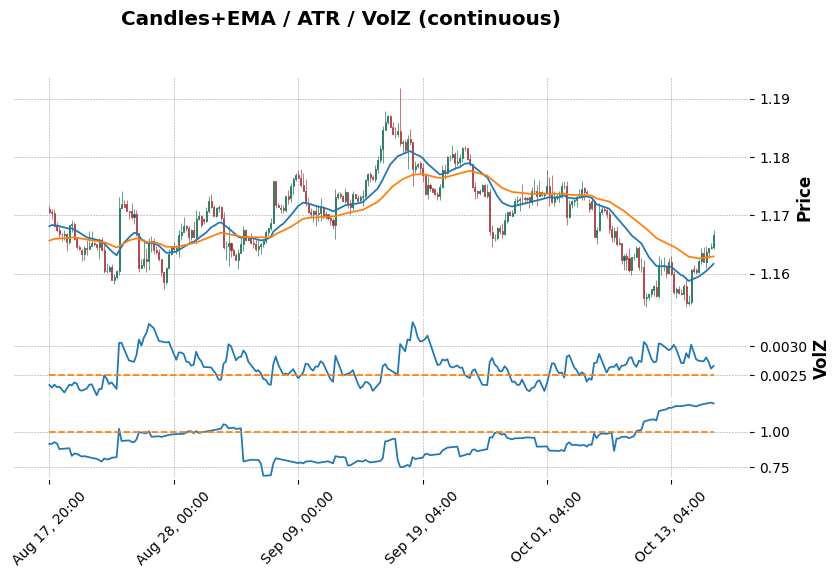

In [16]:
plot_core_dashboard_v2(
    dfc,
    start=dfc.index.max() - pd.Timedelta(days=60),
    end=dfc.index.max(),
    atr_thr=0.0025,
    hspace=0.30
)

In [17]:
from ta.trend import ADXIndicator

def add_adx_feature(df, window=14):
    d = df.copy()
    ind = ADXIndicator(high=d['high'], low=d['low'], close=d['close'], window=window)
    d['adx'] = ind.adx()
    # (ถ้าต้องใช้ต่อภายหลัง สามารถเพิ่ม d['adx_pos'], d['adx_neg'] ได้)
    # TDD: ต้องไม่มี NaN เยอะ และเป็นตัวเลข
    assert d['adx'].dtype.kind in 'fc'
    return d

In [18]:
dfc = add_adx_feature(dfc)
dfc.tail()

,open,high,low,close,volume,ema20,ema50,atr,vol_z,adx
datetime,,,,,,,,,,
2025-10-15 08:00:00,1.16355,1.16453,1.16195,1.16199,16243,1.160077,1.162636,0.002738,1.197292,21.134475
2025-10-15 12:00:00,1.16201,1.16472,1.16103,1.16369,25939,1.160421,1.162678,0.002806,1.201422,20.662785
2025-10-15 16:00:00,1.16371,1.16448,1.16269,1.16441,14745,1.160801,1.162746,0.002734,1.203829,20.224787
2025-10-15 20:00:00,1.16442,1.16519,1.16418,1.16456,5554,1.161159,1.162817,0.002611,1.205963,20.118271
2025-10-16 00:00:00,1.16455,1.16754,1.16425,1.16659,14450,1.161676,1.162965,0.002659,1.199740,20.885051


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mplfinance.original_flavor import candlestick_ohlc

def plot_core_dashboard_continuous(
    df, start=None, end=None,
    atr_thr=0.0030, adx_thr=20,
    title='Candles + EMA / ATR / VolZ / ADX (continuous, no gaps)',
    n_xticks=10   # จำนวนป้ายวัน/เวลาแถวล่าง
):
    # slice
    d = df.loc[str(start):str(end)] if (start or end) else df
    need = {'open','high','low','close','ema20','ema50','atr','vol_z','adx'}
    assert not d.empty and need.issubset(d.columns)

    # x เป็นลำดับแท่ง -> ไม่มีช่องว่างเวลา
    x = np.arange(len(d))
    dt = d.index.to_pydatetime()
    ohlc = np.column_stack([x, d['open'], d['high'], d['low'], d['close']])

    fig = plt.figure(figsize=(12,7), constrained_layout=True)
    gs = fig.add_gridspec(4, 1, height_ratios=[3,1,1,1])

    ax_price = fig.add_subplot(gs[0])
    ax_atr   = fig.add_subplot(gs[1], sharex=ax_price)
    ax_volz  = fig.add_subplot(gs[2], sharex=ax_price)
    ax_adx   = fig.add_subplot(gs[3], sharex=ax_price)

    # --- Candles + EMA ---
    candlestick_ohlc(ax_price, ohlc, width=0.6, colorup='g', colordown='r', alpha=0.9)
    ax_price.plot(x, d['ema20'].values, label='EMA20', linewidth=1.5)
    ax_price.plot(x, d['ema50'].values, label='EMA50', linewidth=1.5)
    ax_price.set_ylabel('Price'); ax_price.legend(loc='best'); ax_price.set_title(title)

    # --- ATR ---
    ax_atr.plot(x, d['atr'].values, label='ATR(14)', linewidth=1.3)
    ax_atr.axhline(atr_thr, ls='--', lw=1.1, label=f'ATR thr={atr_thr:.4f}')
    ax_atr.set_ylabel('ATR'); ax_atr.legend(loc='best')

    # --- VolZ ---
    ax_volz.plot(x, d['vol_z'].values, label='VolZ (50/200)', linewidth=1.3)
    ax_volz.axhline(1.0, ls='--', lw=1.1, label='VolZ=1.0')
    ax_volz.set_ylabel('VolZ'); ax_volz.legend(loc='best')

    # --- ADX (แกนล่างสุดเท่านั้นที่มีป้ายวันเวลา) ---
    ax_adx.plot(x, d['adx'].values, label='ADX(14)', linewidth=1.3)
    ax_adx.axhline(adx_thr, ls='--', lw=1.1, label=f'ADX thr={adx_thr}')
    ax_adx.set_ylabel('ADX'); ax_adx.legend(loc='best')

    # ซ่อนป้ายแกนล่างของแผงบน ๆ
    for ax in (ax_price, ax_atr, ax_volz):
        ax.tick_params(labelbottom=False)

    # ตั้ง xticks แค่ล่างสุด ให้พอดีตา
    n_xticks = max(2, min(n_xticks, len(d)))
    idx = np.linspace(0, len(d)-1, num=n_xticks).astype(int)
    ax_adx.set_xticks(idx)
    ax_adx.set_xticklabels([dt[i].strftime('%b %d\n%H:%M') for i in idx], fontsize=9)

    # เส้นกริดแนวตั้งเบา ๆ (ทั้งหมดใช้ร่วมแกน)
    for ax in (ax_price, ax_atr, ax_volz, ax_adx):
        ax.grid(True, axis='x', alpha=0.15)
        ax.grid(True, axis='y', alpha=0.25)

    plt.show()


In [20]:
print("dfc range:", dfc.index.min(), "->", dfc.index.max(), "rows:", len(dfc))
print("have cols:", sorted(set(dfc.columns) &
       {'open','high','low','close','ema20','ema50','atr','vol_z','adx'}))
print("missing  :", {'open','high','low','close','ema20','ema50','atr','vol_z','adx'} - set(dfc.columns))


dfc range: 2009-10-06 00:00:00 -> 2025-10-16 00:00:00 rows: 25847
have cols: ['adx', 'atr', 'close', 'ema20', 'ema50', 'high', 'low', 'open', 'vol_z']
missing  : set()


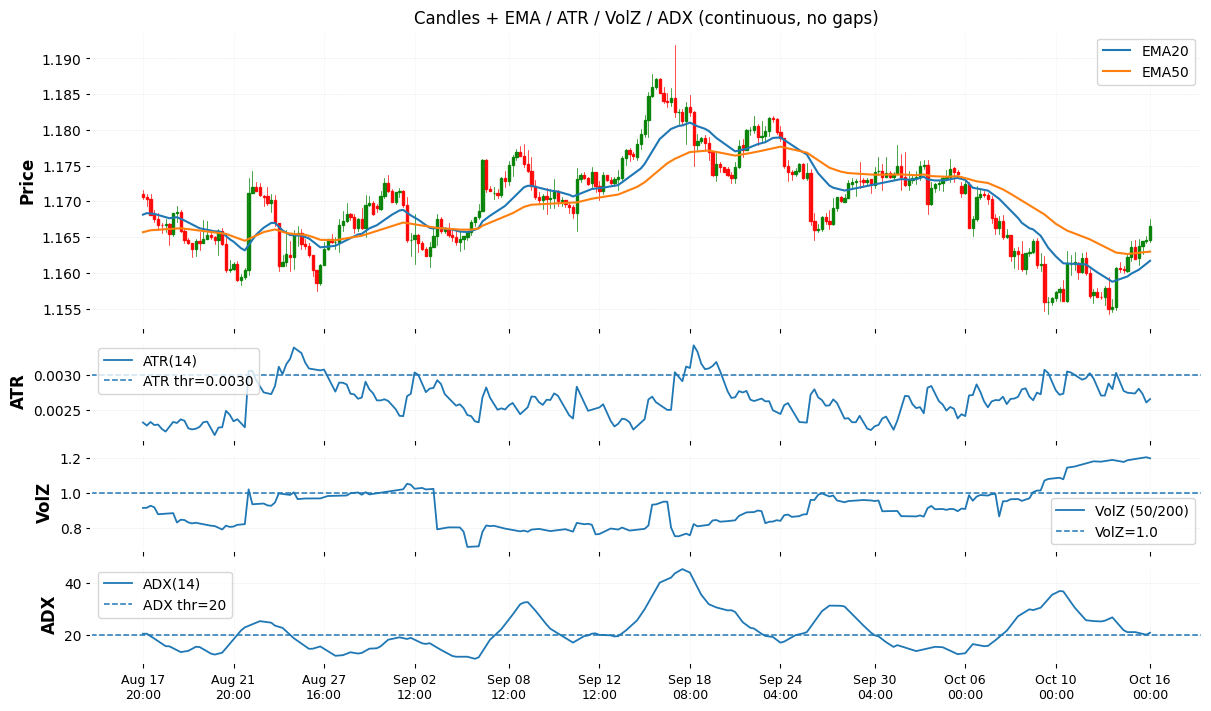

In [21]:
plot_core_dashboard_continuous(
    dfc,
    start=dfc.index.max()-pd.Timedelta(days=60),
    end=dfc.index.max(),
    atr_thr=0.0030, adx_thr=20, n_xticks=12
)


In [22]:
import numpy as np
import pandas as pd

def zigzag_online(prices: pd.Series, pct: float = 0.004):
    """
    ZigZag แบบ online/one-pass
    prices : pd.Series ของ close (index เป็น DatetimeIndex)
    pct    : สัดส่วนการเบี่ยงเบนขั้นต่ำ (เช่น 0.004 = 0.4%)
    return : DataFrame [zz_pivot, zz_pivot_price, zz_swing_dir]
             zz_pivot:  1 = pivot high, -1 = pivot low, 0 = none
             zz_swing_dir: 1=upswing, -1=downswing, 0=undefined
    """
    n = len(prices)
    pivots = np.zeros(n, np.int8)
    pprice = np.full(n, np.nan)
    sdir   = np.zeros(n, np.int8)

    last_p = prices.iloc[0]
    trend  = 0         # 1 up, -1 down, 0 unknown
    extreme = last_p

    def crossed(a, b):
        # เบี่ยงเบนสัมพัทธ์ >= pct
        return abs(b / a - 1.0) >= pct

    for i in range(1, n):
        p = prices.iloc[i]
        if trend == 0:
            if crossed(last_p, p):
                trend = 1 if p > last_p else -1
                extreme = p
        elif trend == 1:
            if p > extreme:
                extreme = p
            elif crossed(extreme, p):
                # ยืนยัน pivot high ที่แท่งก่อนหน้า (extreme เพิ่งถูกทำไว้)
                pivots[i-1] = 1
                pprice[i-1] = extreme
                sdir[i-1]   = 1
                last_p = extreme
                trend  = -1
                extreme = p
        else:  # trend == -1
            if p < extreme:
                extreme = p
            elif crossed(extreme, p):
                pivots[i-1] = -1
                pprice[i-1] = extreme
                sdir[i-1]   = -1
                last_p = extreme
                trend  = 1
                extreme = p

    out = pd.DataFrame(
        {'zz_pivot': pivots, 'zz_pivot_price': pprice, 'zz_swing_dir': sdir},
        index=prices.index
    )
    return out


In [23]:
def add_zigzag_features(df, pct=0.004, overwrite=True):
    out = df.copy()
    zz = zigzag_online(out['close'], pct=pct)  # ต้องคืนคอลัมน์: zz_pivot, zz_pivot_price, zz_swing_dir

    if overwrite:
        out = out.drop(columns=zz.columns, errors='ignore')  # << กันซ้ำ

    out = out.join(zz)
    # ทิศทางสวิงล่าสุด (ffill) สำหรับใช้เป็นบริบท
    out['zz_dir_ffill'] = (
        out['zz_swing_dir'].replace(0, np.nan).ffill().fillna(0).astype('int8')
    )
    return out

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mplfinance.original_flavor import candlestick_ohlc

def plot_core_with_zigzag(
    df, start=None, end=None,
    atr_thr=0.0030, adx_thr=20, zz_pct=0.004,
    title='Candles + EMA / ATR / VolZ / ADX + ZigZag (continuous, no gaps)',
    n_xticks=10
):
    # slice & ensure zigzag cols
    d = df.loc[str(start):str(end)] if (start or end) else df
    need = {'open','high','low','close','ema20','ema50','atr','vol_z','adx'}
    assert not d.empty and need.issubset(d.columns)
    if 'zz_pivot' not in d.columns:
        d = add_zigzag_features(d, pct=zz_pct)

    x = np.arange(len(d))
    dt = d.index.to_pydatetime()
    ohlc = np.column_stack([x, d['open'], d['high'], d['low'], d['close']])

    fig = plt.figure(figsize=(12,7), constrained_layout=True)
    gs  = fig.add_gridspec(4, 1, height_ratios=[3,1,1,1])

    ax_price = fig.add_subplot(gs[0])
    ax_atr   = fig.add_subplot(gs[1], sharex=ax_price)
    ax_volz  = fig.add_subplot(gs[2], sharex=ax_price)
    ax_adx   = fig.add_subplot(gs[3], sharex=ax_price)

    # --- Candles + EMA ---
    candlestick_ohlc(ax_price, ohlc, width=0.6, colorup='g', colordown='r', alpha=0.9)
    ax_price.plot(x, d['ema20'].values, label='EMA20', linewidth=1.4)
    ax_price.plot(x, d['ema50'].values, label='EMA50', linewidth=1.4)

    # --- ZigZag overlay ---
    piv = d['zz_pivot'].values
    ppx = d['zz_pivot_price'].values
    # ตำแหน่งที่เป็น pivot จริง
    piv_idx = np.where(piv != 0)[0]
    if len(piv_idx) >= 2:
        # เชื่อมเส้นระหว่าง pivot ต่อ pivot
        xp = x[piv_idx]
        yp = ppx[piv_idx]
        ax_price.plot(xp, yp, linewidth=1.0, alpha=0.9, label=f'ZigZag {int(zz_pct*10000)/100:.2f}%')
        # ทำ marker ให้เห็นจุด
        hi = piv_idx[piv[piv_idx] == 1]
        lo = piv_idx[piv[piv_idx] == -1]
        ax_price.scatter(x[hi], ppx[hi], marker='o', s=30, label='pivot high')
        ax_price.scatter(x[lo], ppx[lo], marker='o', s=30, label='pivot low')

    ax_price.set_ylabel('Price')
    ax_price.legend(loc='best')
    ax_price.set_title(title)

    # --- ATR ---
    ax_atr.plot(x, d['atr'].values, label='ATR(14)', linewidth=1.2)
    ax_atr.axhline(atr_thr, ls='--', lw=1.0, label=f'ATR thr={atr_thr:.4f}')
    ax_atr.set_ylabel('ATR'); ax_atr.legend(loc='best')

    # --- VolZ ---
    ax_volz.plot(x, d['vol_z'].values, label='VolZ (50/200)', linewidth=1.2)
    ax_volz.axhline(1.0, ls='--', lw=1.0, label='VolZ=1.0')
    ax_volz.set_ylabel('VolZ'); ax_volz.legend(loc='best')

    # --- ADX ---
    ax_adx.plot(x, d['adx'].values, label='ADX(14)', linewidth=1.2)
    ax_adx.axhline(adx_thr, ls='--', lw=1.0, label=f'ADX thr={adx_thr}')
    ax_adx.set_ylabel('ADX'); ax_adx.legend(loc='best')

    # แสดงวันที่เฉพาะล่างสุด
    for ax in (ax_price, ax_atr, ax_volz):
        ax.tick_params(labelbottom=False)
    idx = np.linspace(0, len(d)-1, num=max(2, min(n_xticks, len(d)))).astype(int)
    ax_adx.set_xticks(idx)
    ax_adx.set_xticklabels([dt[i].strftime('%b %d\n%H:%M') for i in idx], fontsize=9)

    for ax in (ax_price, ax_atr, ax_volz, ax_adx):
        ax.grid(True, axis='x', alpha=0.15)
        ax.grid(True, axis='y', alpha=0.25)

    plt.show()


In [25]:
dfc = add_zigzag_features(dfc, pct=0.004)
dfc.tail()

,open,high,low,close,volume,ema20,ema50,atr,vol_z,adx,zz_pivot,zz_pivot_price,zz_swing_dir,zz_dir_ffill
datetime,,,,,,,,,,,,,,
2025-10-15 08:00:00,1.16355,1.16453,1.16195,1.16199,16243,1.160077,1.162636,0.002738,1.197292,21.134475,0,NaN,0,-1
2025-10-15 12:00:00,1.16201,1.16472,1.16103,1.16369,25939,1.160421,1.162678,0.002806,1.201422,20.662785,0,NaN,0,-1
2025-10-15 16:00:00,1.16371,1.16448,1.16269,1.16441,14745,1.160801,1.162746,0.002734,1.203829,20.224787,0,NaN,0,-1
2025-10-15 20:00:00,1.16442,1.16519,1.16418,1.16456,5554,1.161159,1.162817,0.002611,1.205963,20.118271,0,NaN,0,-1
2025-10-16 00:00:00,1.16455,1.16754,1.16425,1.16659,14450,1.161676,1.162965,0.002659,1.199740,20.885051,0,NaN,0,-1


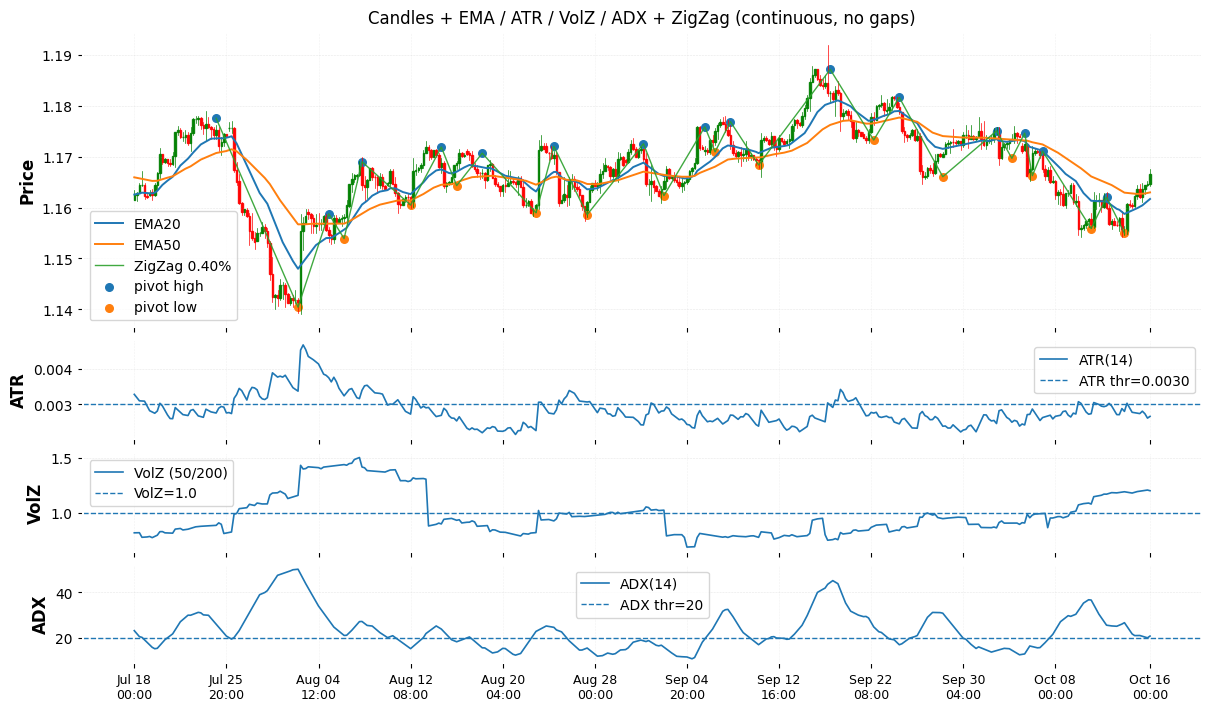

In [26]:
plot_core_with_zigzag(
    dfc,
    start=dfc.index.max()-pd.Timedelta(days=90),
    end=dfc.index.max(),
    atr_thr=0.0030, adx_thr=20,
    zz_pct=0.004,    # 0.4%
    n_xticks=12
)


In [27]:
import numpy as np
import pandas as pd

def apply_cooldown_mask(idx, bars=8, bar_hours=4):
    if len(idx)==0:
        return pd.Series([], dtype=bool)
    keep = []
    last = pd.Timestamp("1970-01-01", tz=getattr(idx, "tz", None))
    dt   = pd.Timedelta(hours=bars*bar_hours)
    for t in idx:
        ok = (t - last) >= dt
        keep.append(ok)
        if ok: last = t
    return pd.Series(keep, index=idx)


In [28]:
def detect_range_boxes(d, lookback=60):
    d = d.copy()
    d['hi_box'] = d['high'].rolling(lookback, min_periods=lookback//2).max()
    d['lo_box'] = d['low'] .rolling(lookback, min_periods=lookback//2).min()
    # ทำให้เส้น step-like (forward-fill)
    d['hi_box'] = d['hi_box'].ffill()
    d['lo_box'] = d['lo_box'].ffill()
    return d


In [29]:
dfc = detect_range_boxes(dfc, lookback=60)
dfc.tail()

,open,high,low,close,volume,ema20,ema50,atr,vol_z,adx,zz_pivot,zz_pivot_price,zz_swing_dir,zz_dir_ffill,hi_box,lo_box
datetime,,,,,,,,,,,,,,,,
2025-10-15 08:00:00,1.16355,1.16453,1.16195,1.16199,16243,1.160077,1.162636,0.002738,1.197292,21.134475,0,NaN,0,-1,1.17591,1.1542
2025-10-15 12:00:00,1.16201,1.16472,1.16103,1.16369,25939,1.160421,1.162678,0.002806,1.201422,20.662785,0,NaN,0,-1,1.17591,1.1542
2025-10-15 16:00:00,1.16371,1.16448,1.16269,1.16441,14745,1.160801,1.162746,0.002734,1.203829,20.224787,0,NaN,0,-1,1.17591,1.1542
2025-10-15 20:00:00,1.16442,1.16519,1.16418,1.16456,5554,1.161159,1.162817,0.002611,1.205963,20.118271,0,NaN,0,-1,1.17591,1.1542
2025-10-16 00:00:00,1.16455,1.16754,1.16425,1.16659,14450,1.161676,1.162965,0.002659,1.199740,20.885051,0,NaN,0,-1,1.17591,1.1542


In [30]:
RULES = dict(
    adx_min=20,
    volz_min=1.0,
    ema_gap_min=0.0003,
    use_trend=True,
    cooldown=8,      # bars
    bar_hours=4
)

def build_rule_stages(df, rules=RULES):
    d = df.copy()
    need = {'ema20','ema50','atr','vol_z','adx','hi_box','lo_box','bos_up','bos_dn','retest_hi','retest_lo'}
    miss = need - set(d.columns)
    assert not miss, f"missing columns: {miss}"

    # base
    L0 = (d['retest_hi'] | d['bos_up'])
    S0 = (d['retest_lo'] | d['bos_dn'])

    # trend
    trend_up = d['ema20'] > d['ema50']
    L1 = L0 & (trend_up if rules['use_trend'] else True)
    S1 = S0 & (~trend_up if rules['use_trend'] else True)

    # ADX
    L2 = L1 & (d['adx'] >= rules['adx_min'])
    S2 = S1 & (d['adx'] >= rules['adx_min'])

    # VolZ
    L3 = L2 & (d['vol_z'] >= rules['volz_min'])
    S3 = S2 & (d['vol_z'] >= rules['volz_min'])

    # EMA gap
    ema_gap = (d['ema20'] - d['ema50']).abs()
    L4 = L3 & (ema_gap >= rules['ema_gap_min'])
    S4 = S3 & (ema_gap >= rules['ema_gap_min'])

    # Cooldown (ทำบน timestamp ที่ “ผ่าน” L4/S4 แล้ว)
    li = d.index[L4]
    si = d.index[S4]
    keepL = apply_cooldown_mask(li, bars=rules['cooldown'], bar_hours=rules['bar_hours'])
    keepS = apply_cooldown_mask(si, bars=rules['cooldown'], bar_hours=rules['bar_hours'])
    L5 = pd.Series(False, index=d.index);  L5.loc[li[keepL]] = True
    S5 = pd.Series(False, index=d.index);  S5.loc[si[keepS]] = True

    out = d.copy()
    # เขียนคอลัมน์ stage (int 0/1)
    for k, v in dict(
        entryL_s0=L0, entryS_s0=S0,
        entryL_s1=L1, entryS_s1=S1,
        entryL_s2=L2, entryS_s2=S2,
        entryL_s3=L3, entryS_s3=S3,
        entryL_s4=L4, entryS_s4=S4,
        entryL_s5=L5, entryS_s5=S5,
    ).items():
        out[k] = v.astype('int8')

    return out


In [31]:
def summarize_stages(d):
    cols = [f'entryL_s{i}' for i in range(6)] + [f'entryS_s{i}' for i in range(6)]
    have = [c for c in cols if c in d.columns]
    tbl = []
    for i in range(6):
        l = d.get(f'entryL_s{i}', pd.Series(0,index=d.index)).sum()
        s = d.get(f'entryS_s{i}', pd.Series(0,index=d.index)).sum()
        tbl.append({'stage': i, 'long': int(l), 'short': int(s), 'total': int(l+s)})
    return pd.DataFrame(tbl)


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mplfinance.original_flavor import candlestick_ohlc

def plot_boxes_bos_retest_stage(df, stage=5, start=None, end=None, adx_thr=20, title=None):
    d = df.loc[str(start):str(end)] if (start or end) else df
    need = {'open','high','low','close','ema20','ema50','hi_box','lo_box',
            'bos_up','bos_dn','retest_hi','retest_lo','adx',
            f'entryL_s{stage}', f'entryS_s{stage}'}
    miss = need - set(d.columns)
    assert not miss, f"missing columns: {miss}"

    x = np.arange(len(d))
    ohlc = np.column_stack([x, d['open'], d['high'], d['low'], d['close']])
    dt  = d.index.to_pydatetime()

    fig = plt.figure(figsize=(13,6), constrained_layout=True)
    gs  = GridSpec(2,1, height_ratios=[4,1], figure=fig)
    axP = fig.add_subplot(gs[0]); axA = fig.add_subplot(gs[1], sharex=axP)

    candlestick_ohlc(axP, ohlc, width=0.6, colorup='g', colordown='r', alpha=0.9)
    axP.plot(x, d['ema20'], label='EMA20', lw=1.6)
    axP.plot(x, d['ema50'], label='EMA50', lw=1.6)
    axP.step(x, d['hi_box'], where='post', color='tab:green', lw=2, label='hi_box')
    axP.step(x, d['lo_box'], where='post', color='tab:red',   lw=2, label='lo_box')

    # BOS/Retest (ให้เห็น context)
    m = d['bos_up'].to_numpy().astype(bool)
    axP.scatter(x[m], d['close'][m], label='BOS↑', marker='o', color='tab:blue', s=30, alpha=.8)
    m = d['bos_dn'].to_numpy().astype(bool)
    axP.scatter(x[m], d['close'][m], label='BOS↓', marker='o', color='tab:orange', s=30, alpha=.8)
    m = d['retest_hi'].to_numpy().astype(bool)
    axP.scatter(x[m], d['close'][m], label='Retest hi', marker='x', color='tab:green', s=45, alpha=.9)
    m = d['retest_lo'].to_numpy().astype(bool)
    axP.scatter(x[m], d['close'][m], label='Retest lo', marker='x', color='tab:red', s=45, alpha=.9)

    # entries ของ stage ที่เลือก
    Lcol = f'entryL_s{stage}'; Scol = f'entryS_s{stage}'
    L = d[Lcol].eq(1).to_numpy(); S = d[Scol].eq(1).to_numpy()
    axP.scatter(x[L], d['close'][L], marker='^', s=60, color='tab:blue',  label=f'Long s{stage}')
    axP.scatter(x[S], d['close'][S], marker='v', s=60, color='tab:brown', label=f'Short s{stage}')

    axP.set_title(title or f"Boxes + BOS/Retest — stage {stage}")
    axP.set_ylabel("Price"); axP.legend(loc='upper left', ncols=4); axP.grid(True, alpha=.25)

    axA.plot(x, d['adx'], label='ADX(14)', lw=1.3)
    axA.axhline(adx_thr, ls='--', lw=1.0, label=f'ADX thr={adx_thr}')
    axA.set_ylabel("ADX"); axA.legend(loc='upper left'); axA.grid(True, alpha=.25)

    idx = np.linspace(0, len(d)-1, num=min(12, max(3, len(d)))).astype(int)
    axA.set_xticks(idx)
    axA.set_xticklabels([dt[i].strftime('%b %d\n%H:%M') for i in idx], fontsize=9)

    plt.show()


In [33]:
need = {'ema20','ema50','atr','vol_z','adx','hi_box','lo_box','bos_up','bos_dn','retest_hi','retest_lo'}
print(need - set(dfc.columns))  # ควรได้ set() ว่าง


{'retest_hi', 'retest_lo', 'bos_dn', 'bos_up'}


In [35]:
def add_bos_retest_v2(d, lookback=60, bos_min_break=0.0, retest_atr=0.5):
    x = d.copy()
    # กล่อง step
    x['hi_box'] = x['high'].rolling(lookback, min_periods=lookback//2).max().ffill()
    x['lo_box'] = x['low'] .rolling(lookback, min_periods=lookback//2).min().ffill()

    # กล่อง "ก่อนหน้า" สำหรับเช็ค BOS
    hi_prev = x['hi_box'].shift(1)
    lo_prev = x['lo_box'].shift(1)

    # BOS: ใช้ high/low ทะลุกล่องเดิม
    x['bos_up'] = (x['high'] > hi_prev + bos_min_break).astype('int8')
    x['bos_dn'] = (x['low']  < lo_prev - bos_min_break).astype('int8')

    # Retest: กลับมาทดสอบระดับเดิมใน tolerance = ATR * mult
    tol = retest_atr * x['atr']
    x['retest_hi'] = ((x['low']  - hi_prev).abs() <= tol).astype('int8')  # ใกล้ hi_prev จากด้านบน
    x['retest_lo'] = ((x['high'] - lo_prev).abs() <= tol).astype('int8')  # ใกล้ lo_prev จากด้านล่าง
    return x


In [36]:
dfc = add_bos_retest_v2(dfc, lookback=60, bos_min_break=0.0, retest_atr=0.4)


   stage  long  short  total
0      0  1544   1816   3360
1      1  1514   1771   3285
2      2  1229   1508   2737
3      3   541    671   1212
4      4   536    669   1205
5      5   213    243    456


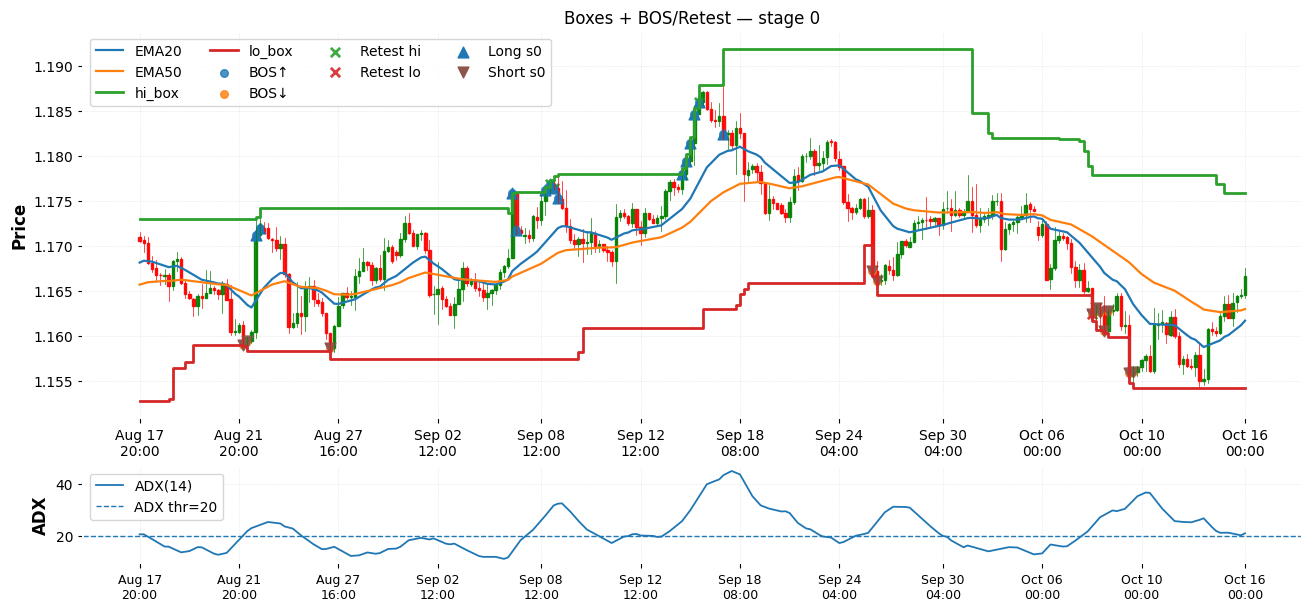

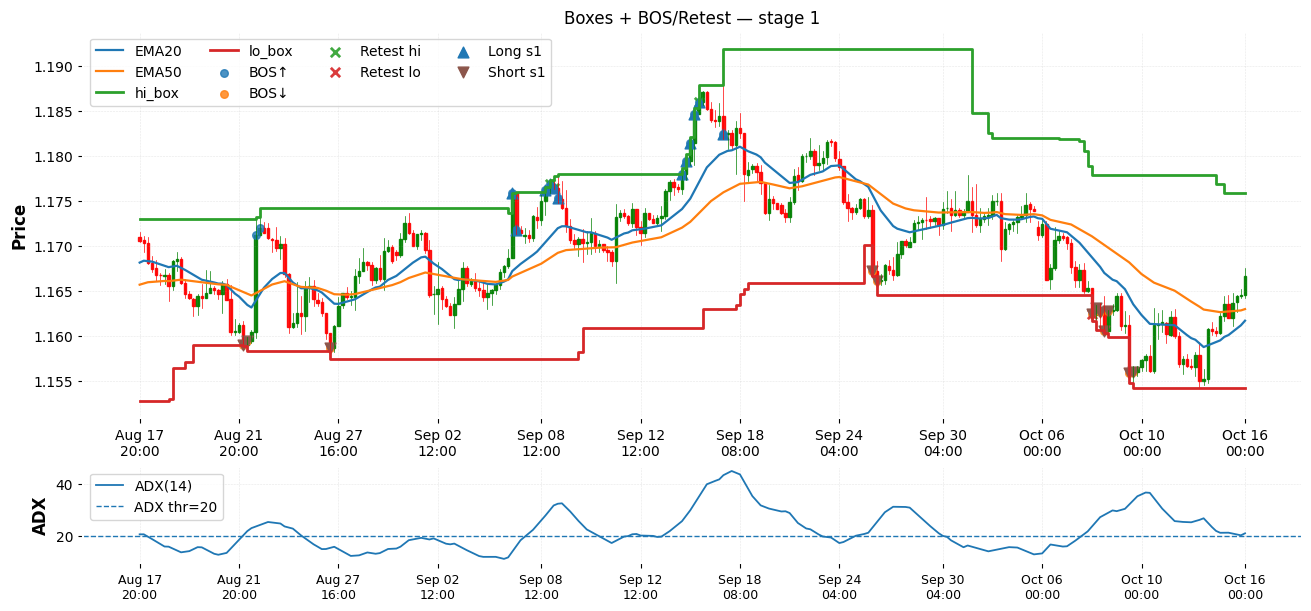

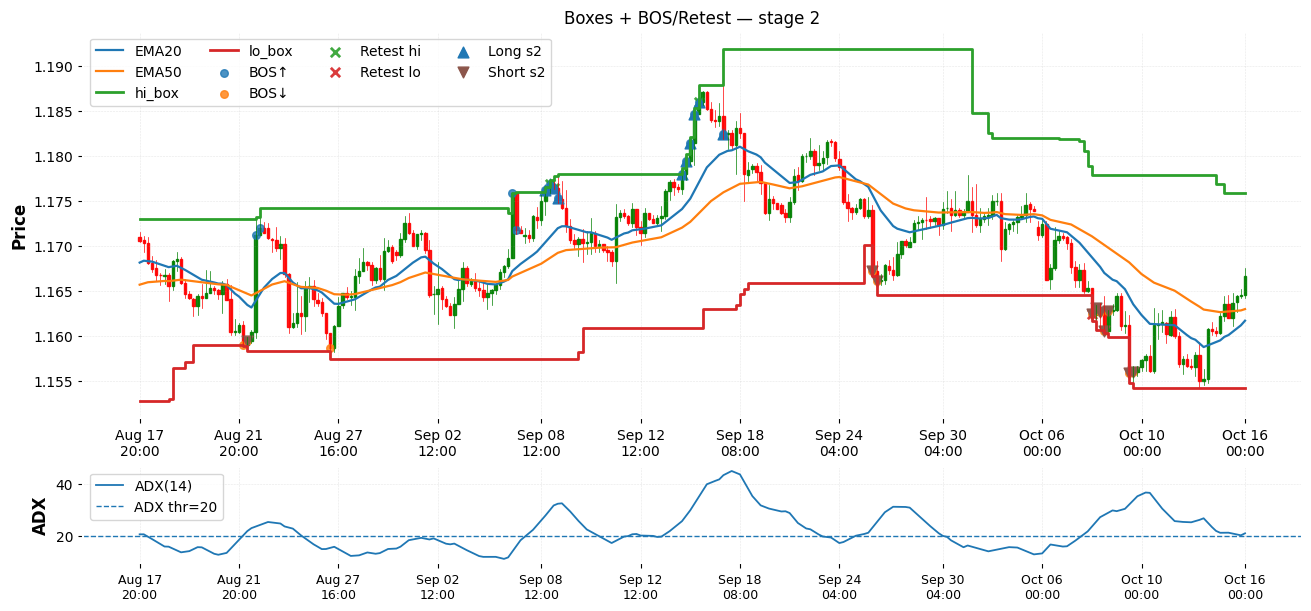

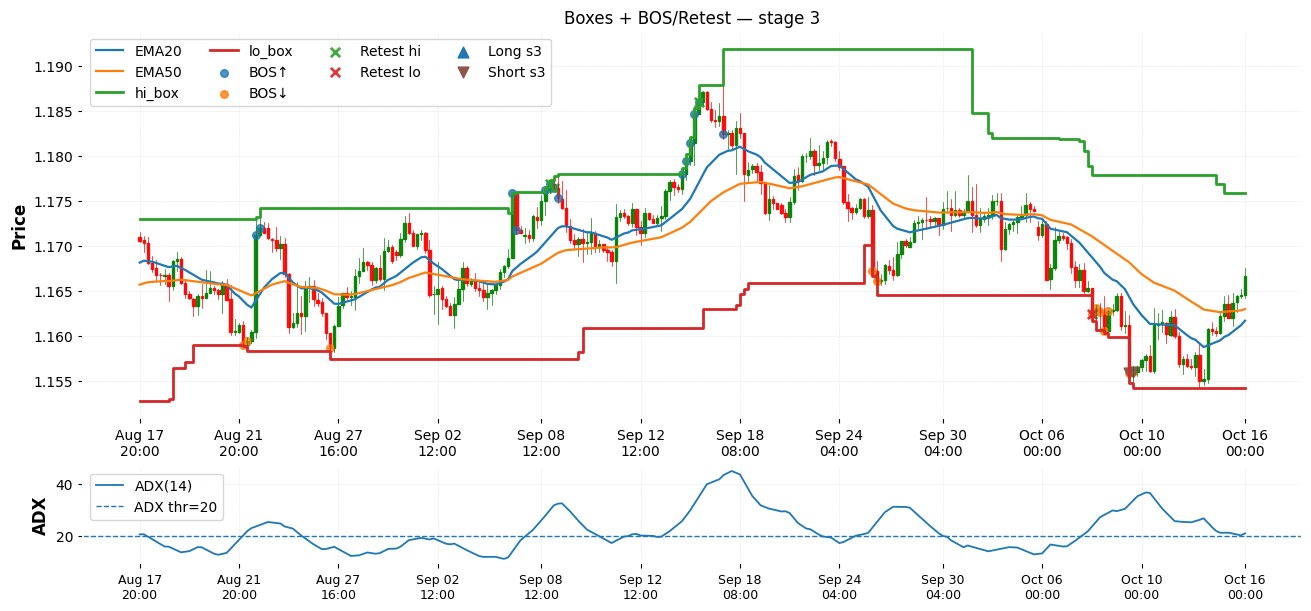

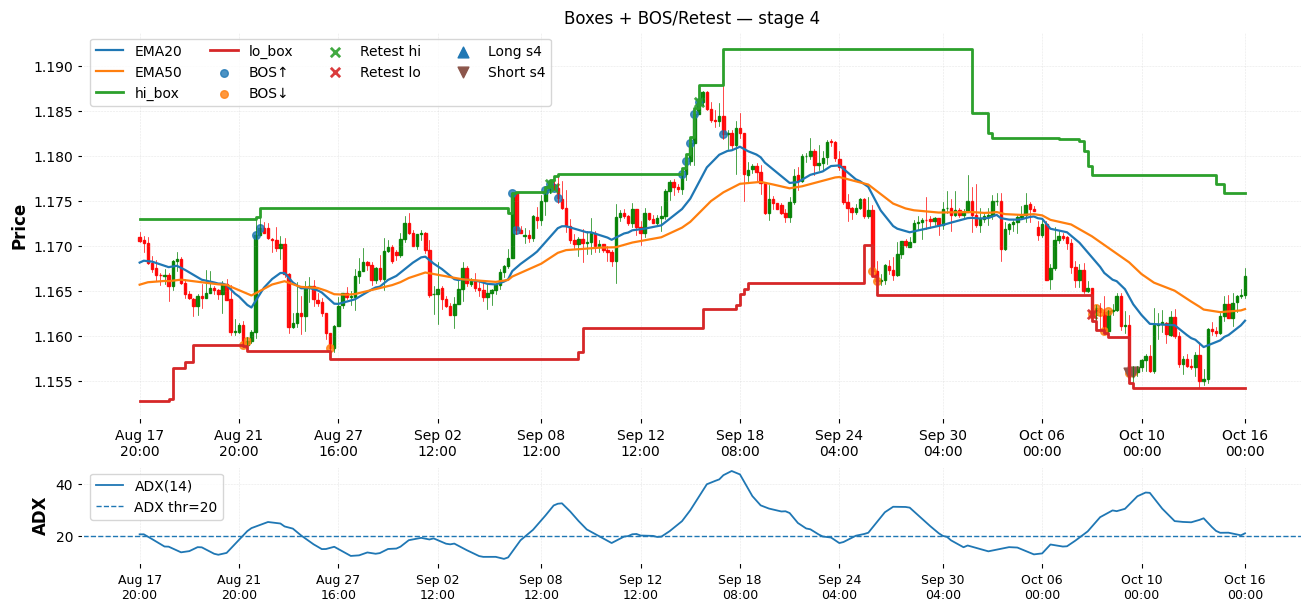

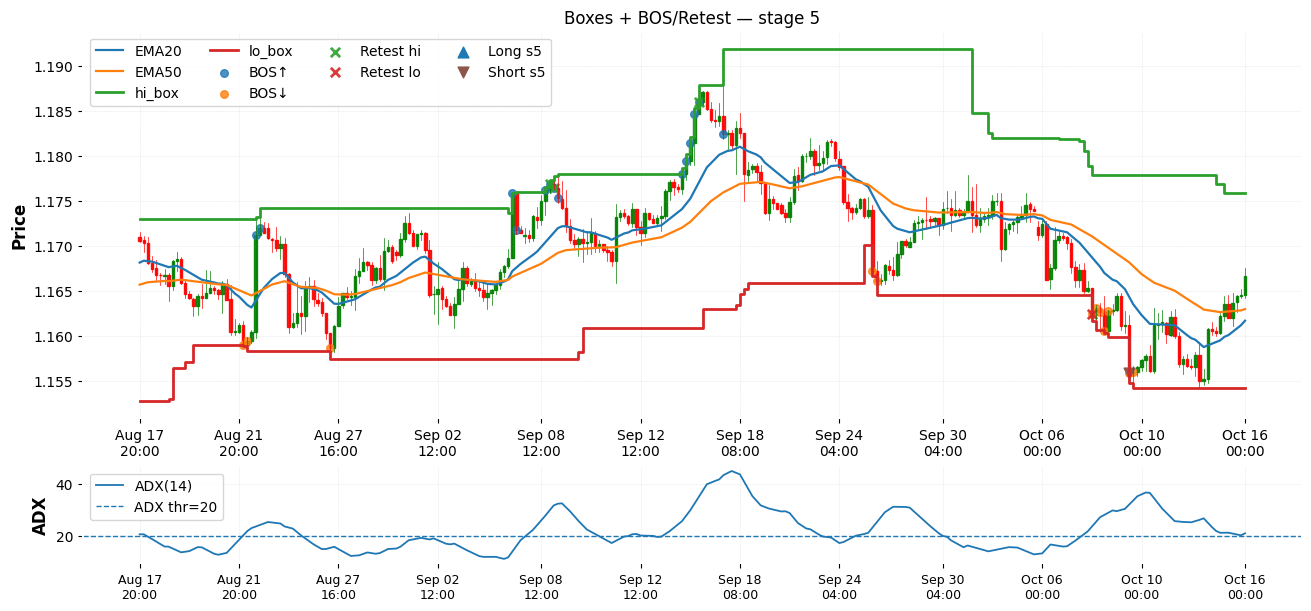

In [37]:
RULES = dict(
    adx_min=20,
    volz_min=1.0,
    ema_gap_min=0.0003,
    use_trend=True,
    cooldown=8,
    bar_hours=4
    )
d = build_rule_stages(dfc, rules=RULES)
print(summarize_stages(d))  # long/short ใน s0..s5

start = d.index.max() - pd.Timedelta(days=60)
end   = d.index.max()
for s in (0,1,2,3,4,5):
    plot_boxes_bos_retest_stage(d, stage=s, start=start, end=end, adx_thr=RULES['adx_min'])
